# Analisis estadistico de los niveles de ruido en una avenida
En este notebook se presenta el analisis estadistico de los datos recabados por los sonometros desplegados en la avenida Eje 5 norte. La finalidad es conocer los niveles de ruido a los que se expone la poblacion cercana. En particular son de ineteres los siguientes parametros estadisticos:

* El valor en decibeles por el cual el nivel de ruido acústico rebasa los 65 dB (nivel considerado como dañino para la salud auditiva de las personas). Este parámetro lo denotaremos por $n_{65}$.
* El intervalo de tiempo durante el cual el nivel de ruido acústico rebasa los 65 dB. Este parámetro lo denotaremos por $t_{65}$.
* El tiempo entre eventos en los que el nivel de ruido rebasa los 65 db.Este parámetro lo denotaremos por $t_e$ .

Los parámetros anteriormente mencionados son variables aleatorias, por lo que el programa
computacional a desarrollar obtendrá el histograma normalizado de cada una de ellas así como
algunos de sus momentos estadísticos (valor medio, coeficiente de variación, entre otros).

## Librerias
Primero se importan las librerias necesarias para poder realizar consultas en la base de datos de InfluxDB2. Tambien se incluyen las librerias que son comunes para los analisis estadisticos.

In [33]:
from influxdb_client import InfluxDBClient, Point, WritePrecision
import pandas as pd
import matplotlib.pyplot as plt
from influxdb_client.client.write_api import SYNCHRONOUS

## Parametros de conexión
Se deben de espesificar los parametros de conexion al servidor en donde se aloja el servicio de InfluxDB2. Estos parametros son:

+ url
+ token
+ organización
+ bucket



In [34]:
# Parámetros de conexión
url = "http://192.168.0.100:8086"
token = "0Gogft785BaN9fzPYk3OdVcO8Qlrt3Y39dA3Ug2IwiJk2TDadgIwmc13AFEMoeakBqkmv08zdr7di072VuMICQ=="
org = "PI"
bucket = "nivel_ruido"

## Consulta de datos
La consulta de los datos se hace usando el lenguaje flux. En esta consulta se espesifica el rango de tiempo y la informacion se filtra dependiendo del numero identificador del nodo del cual se quiera consultar los datos. En este caso la consulta se hace para el nodo sonometro 1 y el rango de tiempo es del 28 de Mayo a las 7:00 a.m. al 29 de Mayo a las 6:00 a.m. timepo de la Ciudad de México.

In [35]:
# Crear el cliente
client = InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()
sonometro = 1
# Definir la consulta en Flux con un rango específico
query = f'''
    from(bucket: "nivel_ruido")
        |> range(start: 2024-05-28T13:00:00Z, stop: 2024-05-29T12:00:00Z)
        |> filter(fn: (r) => r["_measurement"] == "leq")
        |> filter(fn: (r) => r["nodo"] == "{sonometro}")
        |> aggregateWindow(every: 1s, fn: last, createEmpty: false)
        |> yield(name: "last")
'''

In [36]:
# Ejecutar la consulta y obtener resultados
result = query_api.query(org=org, query=query)

Despues, se convierten los datos consultados en un DataFrame. 

In [37]:
# Convertir los resultados a un DataFrame
data = []
for table in result:
    for record in table.records:
        data.append((record.get_time(), record.get_value()))

df = pd.DataFrame(data, columns=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'] - pd.Timedelta(hours=6)
df

,time,value
0,2024-05-28 07:28:25+00:00,55.68
1,2024-05-28 07:28:26+00:00,55.85
2,2024-05-28 07:28:27+00:00,56.25
3,2024-05-28 07:28:28+00:00,55.55
4,2024-05-28 07:28:29+00:00,55.89
...,...,...
77740,2024-05-29 05:59:56+00:00,63.34
77741,2024-05-29 05:59:57+00:00,62.88
77742,2024-05-29 05:59:58+00:00,60.07
77743,2024-05-29 05:59:59+00:00,59.95


## Identificacion de los eventos 
Con el fin de encontrar los parametros estadisticos mencionados al inicio de este documento, es util buscar, a lo largo del tiempo, "eventos" en los cuales los niveles de ruido rebasan el umbral de 65 dB. Se considerará que un evento inicia cuando el ruido supera este umbral y termina cuando decae por debajo de el. Las caracteristicas de estos eventos son:
+ Hora en el que inicia: `start_time`
+ Hora en el que finaliza: `end_time`
+ Valor máximo del ruido durante este evento: `max_values`

In [38]:
# Parámetros para detección de eventos
threshold = 65  # Umbral de ejemplo
min_duration = 3  # Duración mínima del evento en segundos

In [39]:
# Identificación de eventos
events = []
event_start = None
event_values = []
max_value = float('-inf')

for index, row in df.iterrows():
    if row['value'] > threshold:
        if event_start is None:
            event_start = row['time']
            max_value = row['value']
            event_values = [row['value']]
        else:
            max_value = max(max_value, row['value'])
            event_values.append(row['value'])
    else:
        if event_start is not None:
            event_end = row['time']
            duration = (event_end - event_start).total_seconds()
            if duration >= min_duration:
                avg_value = sum(event_values)/len(event_values)
                events.append((event_start, event_end, max_value, avg_value, len(event_values)))
            event_start = None
            max_value = float('-inf')
            event_values = []

In [40]:
# Convertir eventos a DataFrame
events_df = pd.DataFrame(events, columns=['start_time', 'end_time', 'max_value', 'avg_value', 'length'])
events_df['start_time'] = pd.to_datetime(events_df['start_time'])
events_df['end_time'] = pd.to_datetime(events_df['end_time'])

events_df

,start_time,end_time,max_value,avg_value,length
0,2024-05-28 07:30:57+00:00,2024-05-28 07:31:00+00:00,68.10,67.320000,3
1,2024-05-28 07:31:01+00:00,2024-05-28 07:31:05+00:00,75.11,70.852500,4
2,2024-05-28 07:31:14+00:00,2024-05-28 07:31:17+00:00,80.73,76.856667,3
3,2024-05-28 07:31:18+00:00,2024-05-28 07:31:25+00:00,75.34,71.037143,7
4,2024-05-28 07:31:58+00:00,2024-05-28 07:32:01+00:00,70.73,69.600000,3
...,...,...,...,...,...
1821,2024-05-29 05:57:16+00:00,2024-05-29 05:57:29+00:00,75.30,71.155385,13
1822,2024-05-29 05:58:05+00:00,2024-05-29 05:58:09+00:00,68.85,67.862500,4
1823,2024-05-29 05:58:17+00:00,2024-05-29 05:58:36+00:00,83.43,71.321579,19
1824,2024-05-29 05:58:48+00:00,2024-05-29 05:59:01+00:00,83.36,73.982308,13


## Analisis estadistico

Con los eventos convertidos a DataFrames es mas facil calcular los parametros de interes.
Los valores en decibeles por el cual el nivel de ruido acústico rebasa los 65 dB ($n_{65}$) ya estan calculados y estan guardados en la columna de `max_values` del dataFrame `events_df`.

El siguiente codigo se encarga de calcular el tiempo de duracion de los eventos ($t_{65}$) y los guarda en la columna `duration`. Tambien calcula el tiempo entre eventos ($t_e$) y los guarda en la columna `time_diff`.
Tambien calcula el promedio de: el valor maximo, la duracion de los eventos y el tiempo entre eventos.

In [41]:
# Estadísticas de eventos
events_df['duration'] = (events_df['end_time'] - events_df['start_time']).dt.total_seconds()
avg_duration = events_df['duration'].mean()
avg_max_value = events_df['max_value'].mean()
num_events = len(events_df)
most_common_hour = events_df['start_time'].dt.hour.mode()[0]
# Calcular las diferencias de tiempo entre los eventos
events_df['time_diff'] = events_df['start_time'].diff()
events_df['time_diff'] = (events_df['time_diff']).dt.total_seconds()
# Eliminar el primer valor NaT resultante de la diferencia
events_df = events_df.dropna()
# Calcular la diferencia promedio en segundos
avg_time_diff = events_df['time_diff'].mean()
# Calcular la desviacion estandar
desv_duration = events_df['duration'].std()
desv_max_value = events_df['max_value'].std()
desv_time_diff = events_df['time_diff'].std()
events_df = events_df.sort_values(by='duration')

events_df

,start_time,end_time,max_value,avg_value,length,duration,time_diff
1825,2024-05-29 05:59:18+00:00,2024-05-29 05:59:21+00:00,67.33,66.680000,3,3.0,30.0
1161,2024-05-28 20:33:05+00:00,2024-05-28 20:33:08+00:00,65.69,65.476667,3,3.0,25.0
1172,2024-05-28 20:39:40+00:00,2024-05-28 20:39:43+00:00,74.38,70.186667,3,3.0,16.0
1185,2024-05-28 20:49:31+00:00,2024-05-28 20:49:34+00:00,68.37,66.523333,3,3.0,62.0
283,2024-05-28 11:24:06+00:00,2024-05-28 11:24:09+00:00,66.86,66.316667,3,3.0,684.0
...,...,...,...,...,...,...,...
227,2024-05-28 10:16:56+00:00,2024-05-28 10:21:06+00:00,81.66,70.449455,110,250.0,18.0
411,2024-05-28 12:57:05+00:00,2024-05-28 13:01:22+00:00,81.16,70.095439,57,257.0,193.0
287,2024-05-28 11:24:52+00:00,2024-05-28 11:29:16+00:00,79.53,70.661842,114,264.0,28.0
504,2024-05-28 14:09:54+00:00,2024-05-28 14:15:20+00:00,88.33,72.698926,326,326.0,12.0


In [42]:
# Filtrar el dataframe. Eliminar los eventos que tengan perdida de datos.
events_df=events_df[events_df['length']==events_df['duration']]
events_df

,start_time,end_time,max_value,avg_value,length,duration,time_diff
1825,2024-05-29 05:59:18+00:00,2024-05-29 05:59:21+00:00,67.33,66.680000,3,3.0,30.0
1161,2024-05-28 20:33:05+00:00,2024-05-28 20:33:08+00:00,65.69,65.476667,3,3.0,25.0
1172,2024-05-28 20:39:40+00:00,2024-05-28 20:39:43+00:00,74.38,70.186667,3,3.0,16.0
1185,2024-05-28 20:49:31+00:00,2024-05-28 20:49:34+00:00,68.37,66.523333,3,3.0,62.0
283,2024-05-28 11:24:06+00:00,2024-05-28 11:24:09+00:00,66.86,66.316667,3,3.0,684.0
...,...,...,...,...,...,...,...
414,2024-05-28 13:01:55+00:00,2024-05-28 13:05:29+00:00,87.78,71.675280,214,214.0,5.0
1735,2024-05-29 04:51:16+00:00,2024-05-29 04:54:56+00:00,82.22,70.082909,220,220.0,18.0
115,2024-05-28 08:52:45+00:00,2024-05-28 08:56:32+00:00,86.43,70.936079,227,227.0,7.0
420,2024-05-28 13:08:19+00:00,2024-05-28 13:12:20+00:00,87.96,71.065021,241,241.0,11.0


In [43]:
print(f'Duración promedio de eventos: {avg_duration:.2f} segundos')
print(f'Valor máximo promedio: {avg_max_value:.2f}')
print(f'Número de eventos: {num_events}')
print(f'Hora más común de inicio de eventos: {most_common_hour}:00')
print(f'Tiempo promedio entre eventos: {avg_time_diff:.2f} segundos')
print(f'Desviacion estandar del valor máximo: {desv_max_value:.2f}')
print(f'Desviacion estandar de la duaración de los eventos: {desv_duration:.2f}')
print(f'Desviacion estandar del tiempo entre eventos: {desv_time_diff:.2f}')

Duración promedio de eventos: 21.35 segundos
Valor máximo promedio: 73.78
Número de eventos: 1826
Hora más común de inicio de eventos: 21:00
Tiempo promedio entre eventos: 44.33 segundos
Desviacion estandar del valor máximo: 6.27
Desviacion estandar de la duaración de los eventos: 36.32
Desviacion estandar del tiempo entre eventos: 52.13


### Histograma general 
El histograma general sera de ayuda para ver la distribucion de los datos.


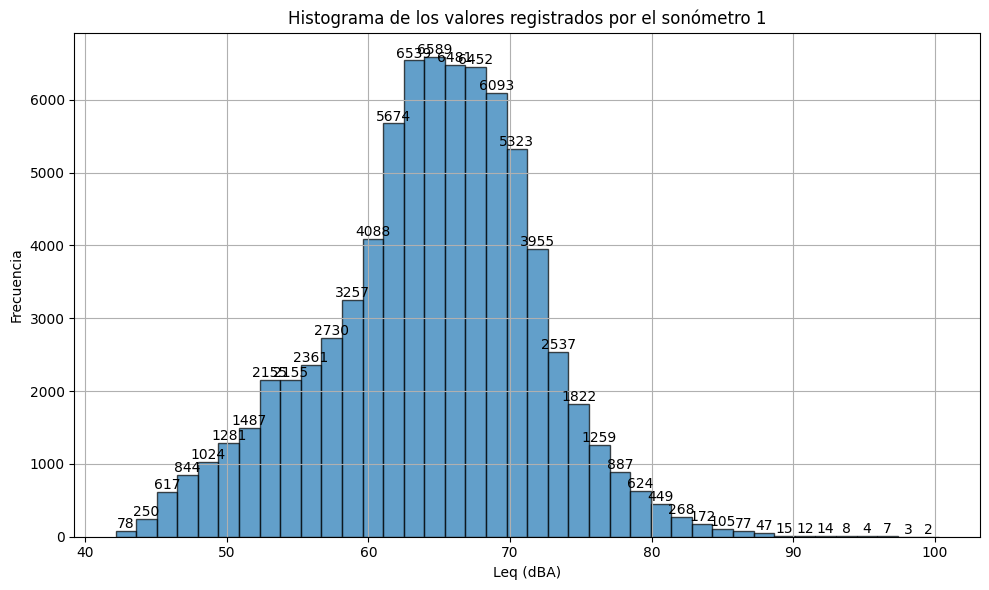

In [44]:
plt.figure(figsize=(10, 6))
[n, bins, patches]=plt.hist(df['value'], bins=40, edgecolor='k', alpha=0.7)
plt.title(f'Histograma de los valores registrados por el sonómetro {sonometro}')
plt.xlabel('Leq (dBA)')
plt.ylabel('Frecuencia')
for p in patches:
    height = p.get_height()
    plt.annotate(f'{height:.0f}', (p.get_x() + p.get_width()/2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.grid(True)
plt.tight_layout()
plt.show()

### Histograma de la duración de eventos
Este histograma muestra que la mayoria de los eventos tiene una duracion corta de entre 3 y 25 segundos. lo cual concuerda con el promedio de duracion de eventos que es de 23.32

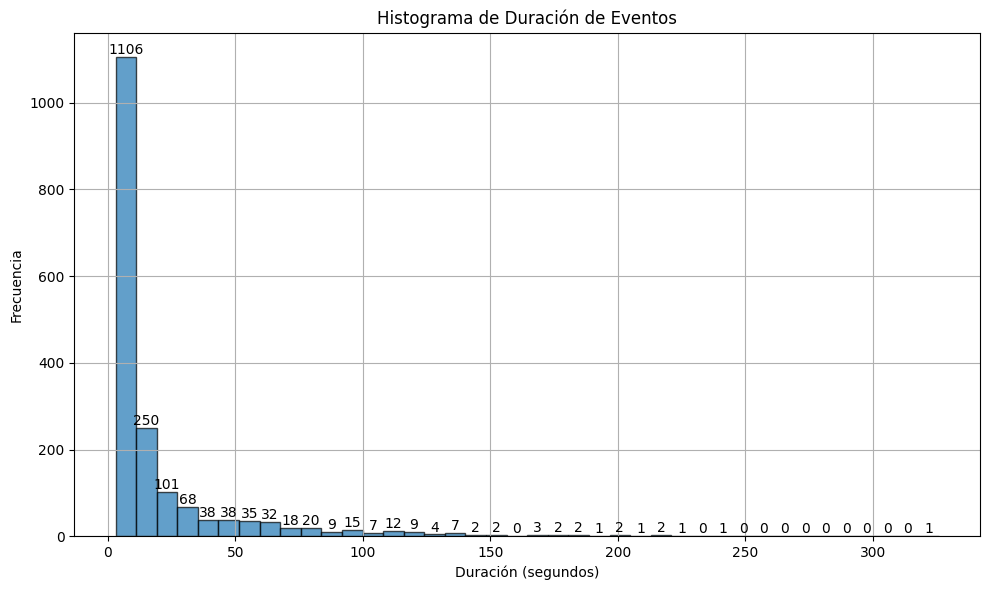

In [52]:
plt.figure(figsize=(10, 6))
[n, bins, patches]=plt.hist(events_df['duration'], bins=40, edgecolor='k', alpha=0.7)
plt.title('Histograma de Duración de Eventos')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
for p in patches:
    height = p.get_height()
    plt.annotate(f'{height:.0f}', (p.get_x() + p.get_width()/2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.grid(True)
plt.tight_layout()
plt.show()

### Histograma del tiempo entre eventos


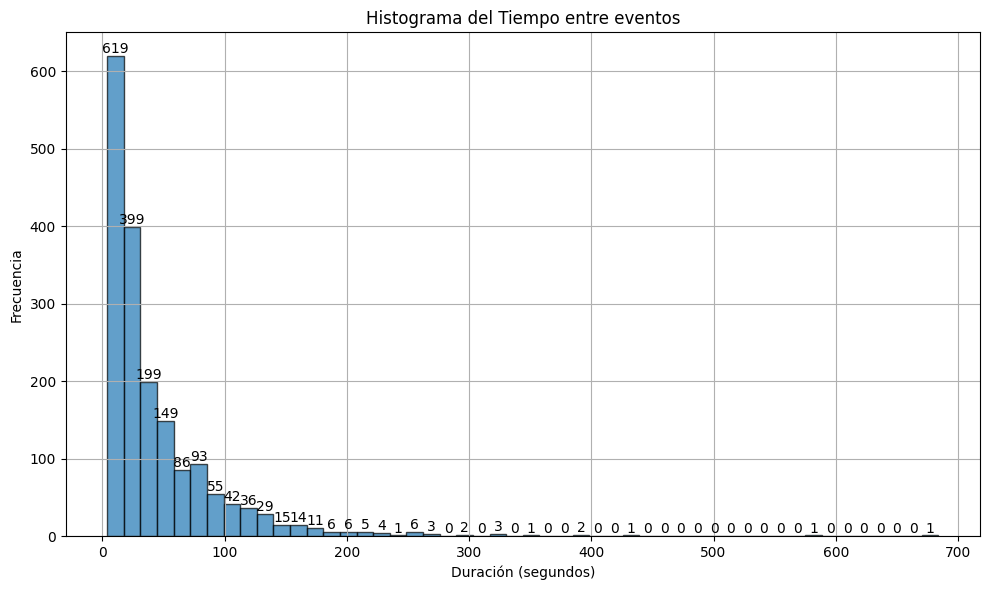

In [46]:
plt.figure(figsize=(10, 6))
[n, bins, patches]=plt.hist(events_df['time_diff'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Histograma del Tiempo entre eventos')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
for p in patches:
    height = p.get_height()
    plt.annotate(f'{height:.0f}', (p.get_x() + p.get_width()/2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.grid(True)
plt.tight_layout()
plt.show()

### Histograma del valor maximo de los eventos


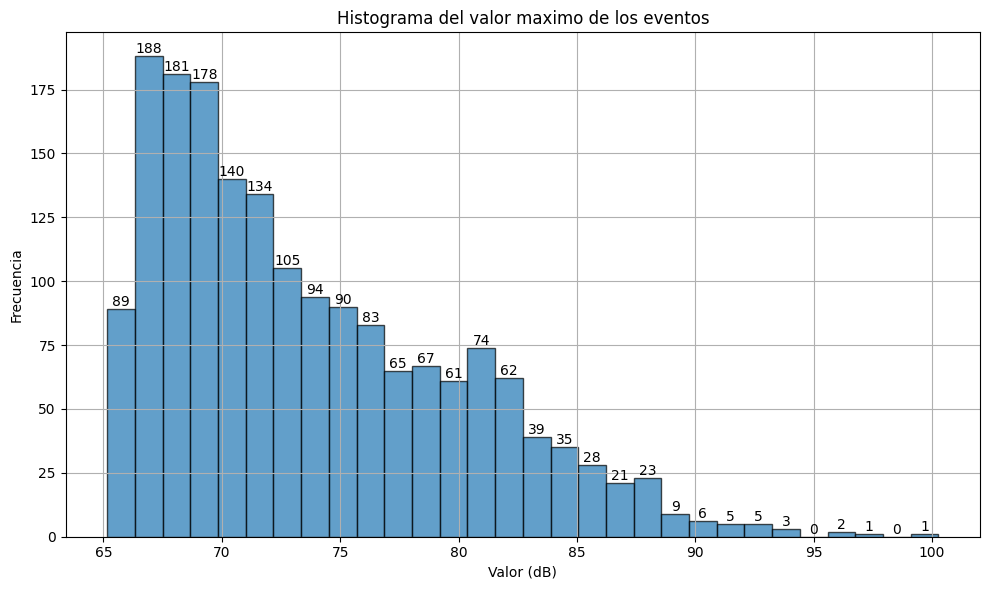

In [47]:
plt.figure(figsize=(10, 6))
[n, bins, patches]=plt.hist(events_df['max_value'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma del valor maximo de los eventos')
plt.xlabel('Valor (dB)')
plt.ylabel('Frecuencia')
for p in patches:
    height = p.get_height()
    plt.annotate(f'{height:.0f}', (p.get_x() + p.get_width()/2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.grid(True)
plt.tight_layout()
plt.show()

### Parametros estadisticos generales
En esta parte se obtienen el promedio, la mediana y la desviacion estandar de todos los datos registrados en el horario espesifico de la consulta.


In [48]:
# Estadísticas generales
promedio_general = df['value'].mean()
mediana_general = df['value'].median()
desv_general = df['value'].std()
print(f'Promedion general de los niveles de ruido registrado por el sonometro {sonometro}: {promedio_general:.2f}')
print(f'Mediana general de los niveles de ruido registrado por el sonometro {sonometro}: {mediana_general:.2f}')
print(f'Desviacion general de los niveles de ruido registrado por el sonometro {sonometro}: {desv_general:.2f}')


Promedion general de los niveles de ruido registrado por el sonometro 1: 64.35
Mediana general de los niveles de ruido registrado por el sonometro 1: 64.93
Desviacion general de los niveles de ruido registrado por el sonometro 1: 7.43


### Niveles percentiles
Los niveles percentiles de ruido son métricas que ayudan a entender la variabilidad y la distribución de los niveles de ruido en un período de tiempo. Un nivel percentil, como el L10, indica que el nivel de ruido fue igual o superado durante el 10% del tiempo. De manera similar, el L50 y el L90 indican los niveles de ruido que se igualaron o superaron el 50% y el 90% del tiempo, respectivamente. Estos valores son útiles para identificar los niveles de ruido más comunes y los picos de ruido en un entorno específico.

In [49]:
# Niveles percentiles
# ordenar el dataframe con los valores
percentiles = df['value'].quantile([0.10, 0.50, 0.90])
df=df.sort_values(by='value')
print(percentiles)

0.1    53.80
0.5    64.93
0.9    72.93
Name: value, dtype: float64


In [50]:
print(f'Duración promedio de eventos: {avg_duration:.2f} segundos')
print(f'Valor máximo promedio: {avg_max_value:.2f}')
print(f'Número de eventos: {num_events}')
print(f'Hora más común de inicio de eventos: {most_common_hour}:00')
print(f'Tiempo promedio entre eventos: {avg_time_diff:.2f} segundos')

Duración promedio de eventos: 21.35 segundos
Valor máximo promedio: 73.78
Número de eventos: 1826
Hora más común de inicio de eventos: 21:00
Tiempo promedio entre eventos: 44.33 segundos
